In [1]:
import pandas as pd 
import numpy as np
import requests
import os
from dotenv import load_dotenv
import json
import tqdm
load_dotenv()

API_key = os.getenv('API_key')

In [2]:
air_data = pd.read_feather('air_data.feather')

In [3]:
air_data = air_data.loc[air_data['lat'] > 0]

In [4]:
#mask = ~air_data[[col for col in air_data.columns if 'present' in col or 'future' in col]].isnull().any(axis=1)

In [5]:
#air_data = air_data.loc[mask]

In [6]:
particles = ['NO2', 'O3', 'PM10', 'PM25']

In [7]:
percentiles = {particle: np.percentile(air_data[f'{particle}_present'], 90) for particle in particles}

In [8]:
mask = np.zeros((len(air_data), )).astype(bool)
for particle in particles: 
    mask = mask | (air_data[f'{particle}_present'] > percentiles[particle])

In [9]:
#air_data = air_data.loc[mask]

In [10]:
#air_data = air_data.sample(49000, replace=False)

In [11]:
def return_request(lat, lon, start, end):
    return f'https://history.openweathermap.org/data/2.5/history/city?lat={lat}&lon={lon}&type=hour&start={start}&end={end}&appid={API_key}'

In [12]:
air_data['time_unix_utc'] = air_data['time_unix'] - 3600

In [13]:
air_coords = air_data[['lat','lng', 'time_unix_utc']]\
    .groupby(['lat','lng'])\
    .apply(lambda x: sorted(x['time_unix_utc']))\
    .reset_index()\
    .rename({0: 'timestamps'}, axis=1)

In [14]:
json_folder = 'jsons'
if not os.path.exists(json_folder):
    os.mkdir(json_folder)

In [15]:
def write_response(response, lat, lng):
    with open(os.path.join(json_folder, f'{lat}_{lng}.json'), 'w') as file: 
        json.dump(response, file)

In [16]:
seconds_in_year = 31_536_000
seconds_in_30days = 2_592_000

In [17]:
months_skipped = []
for i, row in tqdm.tqdm(air_coords[['timestamps', 'lat','lng']].iterrows(), total=len(air_coords)):
    lat, lng = row['lat'], row['lng']
    if os.path.exists(os.path.join(json_folder, f'{lat}_{lng}.json')):
        continue
    response = {'code': 400000, 'message': 'requested data is out of allowed range'}
    months =  0
    while ('code' in response and response['code'] == 400000) and min(row['timestamps']) + seconds_in_30days*months < max(row['timestamps']):
        request_url = return_request(lat, lng, min(row['timestamps']) + seconds_in_30days*months, max(row['timestamps']))
        response = requests.get(request_url).json()
        months += 1
    response['start'] = min(row['timestamps']) + seconds_in_30days*(months-1)
    response['end'] = max(row['timestamps'])
    write_response(response, lat, lng)
    months_skipped.append(months)

100%|██████████████████████████████████████████████████████████████████████████████| 393/393 [4:32:39<00:00, 41.63s/it]


(array([51., 18., 15., 16.,  6., 15., 71.,  2.,  1., 16.,  2.,  4.,  4.,
         0.,  0.,  3.,  1.,  1.,  1.,  7.]),
 array([ 0.16666667,  1.275     ,  2.38333333,  3.49166667,  4.6       ,
         5.70833333,  6.81666667,  7.925     ,  9.03333333, 10.14166667,
        11.25      , 12.35833333, 13.46666667, 14.575     , 15.68333333,
        16.79166667, 17.9       , 19.00833333, 20.11666667, 21.225     ,
        22.33333333]),
 <BarContainer object of 20 artists>)

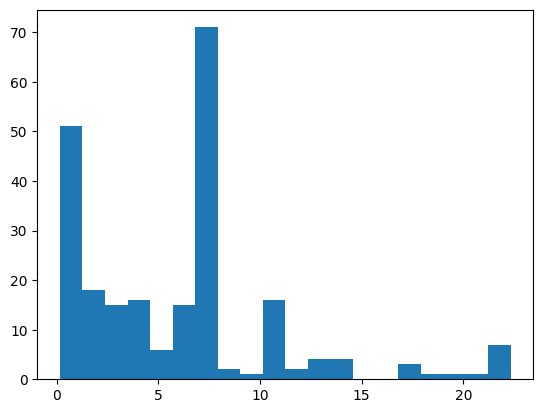

In [19]:
from matplotlib import pyplot as plt
plt.hist([month/12 for month in months_skipped], bins=20)